In [1]:
%load_ext autoreload
%autoreload 2

from src.utils import load_json, save_json
import pandas as pd
import re
from itertools import chain
from collections import defaultdict
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem


# Negotiate combo of rhea flat files and up pull

In [3]:
# Rhea flat files and UP pull

rhea_directions = pd.read_csv('/home/stef/bottle/data/sprhea/rhea-directions.tsv', '\t')
rhea_smarts = pd.read_csv('/home/stef/bottle/data/sprhea/rhea-reaction-smiles.tsv', '\t', header=None)
rhea_smarts.columns = ["rhea_id", "smarts"]
rhea_smarts.set_index('rhea_id', inplace=True)
rhea_uniprot = pd.read_csv('/home/stef/bottle/data/sprhea/rhea2uniprot_sprot.tsv', sep='\t')
up_pull = pd.read_csv('/home/stef/bottle/data/sprhea/uniprotkb_reviewed_true_AND_proteins_wi_2024_02_29.tsv', sep='\t')
up_pull.set_index("Entry", inplace=True)

/home/stef/miniconda3/envs/mine/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
# Rhea IDs w smarts are a subset of all ids in rhea-directions

rhea_all = set()
for col in rhea_directions.columns:
    rhea_all = rhea_all | set(rhea_directions.loc[:, col])
w_smarts = set(rhea_smarts.index.values)
w_smarts - rhea_all

set()

In [5]:
# Only rhea IDs in LR & RL columns of rhea directions have a smarts entry, and if there is one there are both!

codes = []
counts = []
for i, row in rhea_directions.iterrows():
    ct = 0
    code = ''
    for id in row:
        if id in w_smarts:
            ct += 1
            code += '1'
        else:
            code += '0'
    counts.append(ct)
    codes.append(code)

print(set(counts))
print(rhea_directions.columns)
print(set(codes))

{0, 2}
Index(['RHEA_ID_MASTER', 'RHEA_ID_LR', 'RHEA_ID_RL', 'RHEA_ID_BI'], dtype='object')
{'0110', '0000'}


In [10]:
rhea_directions.loc[rhea_directions['RHEA_ID_MASTER'] == 57888]

,RHEA_ID_MASTER,RHEA_ID_LR,RHEA_ID_RL,RHEA_ID_BI
11417,57888,57889,57890,57891


In [84]:
# Create look up of (LR, RL) rhea ids from not LR, RL

lookup_directed_ids = {}

for i, row in rhea_directions.iterrows():
    lookup_directed_ids[row['RHEA_ID_MASTER']] = (row['RHEA_ID_LR'], row['RHEA_ID_RL'])
    lookup_directed_ids[row['RHEA_ID_BI']] = (row['RHEA_ID_LR'], row['RHEA_ID_RL'])

In [86]:
# Get rhea ids UniProt pull

rhea_up_pairs_pull= set()
pattern = r'RHEA:(\d{1,6})' # Regular expression pattern
no_matches = []

for entry, row in up_pull.iterrows():
    cat_act = row["Catalytic activity"]
    if pd.isna(cat_act):
        no_matches.append(entry)
    else:
        matches = re.findall(pattern, cat_act)

        for match in matches:
            rhea_up_pairs_pull.add((int(match), entry))

        if len(matches) == 0:
            no_matches.append(entry)

In [87]:
# Pull rhea-up pairs from rhea's tsv

rhea_up_pairs_flat = set()
for i, row in rhea_uniprot.iterrows():
    rhea_up_pairs_flat.add((row['RHEA_ID'], row['ID']))

In [88]:
# Difference between uppull and rhea pairs is small
len(rhea_up_pairs_flat ^ rhea_up_pairs_pull) / len(rhea_up_pairs_flat | rhea_up_pairs_pull)

0.006352646521386967

In [73]:
# Filter by smarts avail

def filter_pairs_by_smarts(pair):
    r = pair[0]
    if r in w_smarts:
        return True
    elif r in lookup_directed_ids:
        if lookup_directed_ids[r][0] in w_smarts or lookup_directed_ids[r][1] in w_smarts:
            return True
        else:
            return False
    else:
        return False

rhea_up_pairs_pull_w_smarts = set(filter(filter_pairs_by_smarts, list(rhea_up_pairs_pull)))
rhea_up_pairs_flat_w_smarts = set(filter(filter_pairs_by_smarts, list(rhea_up_pairs_flat)))

In [74]:
# After filtering by avail of smarts, the difference in rhea-upid pairs
# gotten by the two methods is even smaller

len(rhea_up_pairs_pull_w_smarts ^ rhea_up_pairs_flat_w_smarts) / len(rhea_up_pairs_flat_w_smarts | rhea_up_pairs_pull_w_smarts)

0.005960904846727906

In [110]:
# Translate rhea ids into LR or RL ids since these are the only ones with smarts

pairs_w_smarts = rhea_up_pairs_pull_w_smarts | rhea_up_pairs_flat_w_smarts
translated_pairs_w_smarts = set()
for r, p in pairs_w_smarts:
    if r in w_smarts: # Was already in LR / RL
        translated_pairs_w_smarts.add((r, p))
    elif r not in lookup_directed_ids: # Was not and can't find LR/RL in lookup
        continue
    else: # Was not but found in lookup
        if lookup_directed_ids[r][0] in w_smarts: # Found LR in w smarts
            translated_pairs_w_smarts.add((lookup_directed_ids[r][0], p))
        if lookup_directed_ids[r][1] in w_smarts: # Found RL in w smarts
            translated_pairs_w_smarts.add((lookup_directed_ids[r][1], p))


In [111]:
# Save to scrape smi-name pairs from website

rheas_to_get, _ = list(zip(*translated_pairs_w_smarts))
rheas_to_get = list(set(rheas_to_get))

with open("../data/sprhea/rheas_to_get_names.txt", 'w') as f:
    for elt in rheas_to_get:
        f.write(f"{elt}\n")

print(len(rheas_to_get))

24044


In [119]:
# Save all rhea-uniprot pairs from pull and flat file 
# that have smarts

rhea2uniprot = defaultdict(set)
for r,p in translated_pairs_w_smarts:
    rhea2uniprot[int(r)].add(p)

for k, v in rhea2uniprot.items():
    rhea2uniprot[k] = list(v)

print(len(rhea2uniprot))

save_json(rhea2uniprot, "../data/sprhea/rhea2uniprot_all.json")

24044


In [118]:
# Found smi-name pairs for most reactions

# rhea_smi_name = load_json('/home/stef/bottle/data/sprhea/rhea_smiles_names.json')
# print(len(rhea_smi_name))

# rhea2smi2name = defaultdict(lambda : defaultdict())
# for rid, elt in rhea_smi_name.items():
#     if elt is None:
#         continue
#     for side in ['left', 'right']:
#         for pair in elt[side]:
#             rhea2smi2name[rid][pair['smiles']] = pair['label']
# print(len(rhea2smi2name))

24044
24028


In [58]:
smiles_from_smarts = set()
for i,row in rhea_smarts.iterrows():
    this_smiles = list(chain(*[elt.split('.') for elt in row['smarts'].split('>>')]))
    for smi in this_smiles:
        smiles_from_smarts.add(smi)

smiles_from_smarts = list(smiles_from_smarts)
print(len(smiles_from_smarts))

12272


In [111]:
krsv2 = load_json('/home/stef/bottle/data/mapping/known_rxns_swissprot_enzymes_240310_v2.json')
len(krsv2)


{'smarts': 'NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)c1>>NC(=O)c1cccnc1.Nc1ncnc2c1ncn2C1OC2COP(=O)(O)OP(=O)(O)OCC3OC(OC1C2O)C(O)C3O',
 'imt_rules': [],
 'min_rules': [],
 'enzymes': [['I1GTC2',
   'MASSGLSSRRSIMASRLTASAEAVNEPRRGAVVSRRVEYDEESLAGAGGESRYEVFINHRGVDTKRTVARLLYDRLAQAGLRGFLDNMSMRPGDRLEERIGSAIRECTVAVAIFSPSYCDSEYCLRELAMLVESRKAIIPIFYDIKPSDLLLPQAVADSEVYLPRDLERFKFALREAKHTVGITYDSATGDMAELVSAAADAVMYNMEKMETVQRRETMILSRL',
   ['3.2.2.6'],
   1.0,
   'Evidence at protein level',
   'reviewed',
   'Brachypodium distachyon (Purple false brome) (Trachynia distachya)'],
  ['A0A290U7C4',
   'MLTSSSHHGRSYDVFLSFRGEDTRKTFVGHLFNALIEKGIHTFMDDKELKRGKSISSELMKAIGESRFAVVVFSKNYASSTWCLEELVKILEIHEKFELIVVPVFYDVDPSTVRKQNGEYAVCFTKFEANLVDDRDKVLRWREALTKVANISGHDLRNTYNGDESKCIQQILKDIFDKFCFSISITNRDLVGIESQIKKLSSLLRMDLKGVRLVGIWGMGGVGKTTAARALFNRYYQNFESACFLEDVKEYLQHHTLLYLQKTLLSKLLKVEFVDCTDTEEMCVILKRRLCSKKVLVVLDDVNHNDQLDKLVGAEDWFGSGSRIVITTRDMKLLKNHDVHETYEIKVLEKDEAIELFNLHAFKRSSPEKE

In [114]:

krsv2[list(krsv2.keys())[3]]

{'smarts': 'NC(=O)c1cccnc1.Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)OCC2OC(O)C(O)C2O)C(O)C1O>>NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)c1.O',
 'imt_rules': ['rule0310_1'],
 'min_rules': ['rule0310'],
 'enzymes': [['Q28FQ6',
   'MMAAGVSRFRGSLLGALLGDCIGAVFEGHTNVTKEFLFDYMKSLDKGERLKRVLTYTDDTAMARSIVQSVLENYEFNIEDLANRFTTEYNRDPDRGYGMAVVHVFEKLGSGEYKHVFSPAREQFDGKGSYGNGAAMRVVGISLAYPRIPDIIEYARTSGMLTHASSLGYNGAILQALAVHYALQGELAPETFLDQLLDHMKEVETDKKSRSDALELEMDEFPYCNKLRKIKAFLAREDVTRKDIVKELGNGIQAFESVPTAIYSFLRCLKPVSELPSELTNLQRTIAFCILLGGDTDTIATMAAAIAGAYHGEEQIPLNWKLSAEGYKDAEDWGEKLHQLYCRRLQSTTS',
   ['3.2.1.143'],
   1.0,
   'Evidence at transcript level',
   'reviewed',
   'Xenopus tropicalis (Western clawed frog) (Silurana tropicalis)'],
  ['F1QWA8',
   'MFLSLVVYLSKICRYLSMFSSDRLTVPEYVSSRLHNRRTAPDPRAVSPGISTDVQAVLDGSLPALRSAIRTLRSSKDTGDLEETRRAIAETFQLVEEAWVLPTVGRRVAEEICNRIRLDGGLELLLQLMQTPAVEITYESAKLLEQILVSENRDYVARMGLGVILNLTREQEDAQLARSVSGILEHMFKHTEETSAQLITNGALDTILYWCRGTDPTVLR

In [48]:
# Similar amount of reactions to v2

krsv3 = load_json('/home/stef/bottle/data/sprhea/sprhea_240310_v3.json')
krsv3 = {int(k) : v for k,v in krsv3.items()}
len(krsv3)

20440

In [ ]:
rxnid = 0

In [109]:
# Spot checks

rxnid += 1
print(rxnid)
krsv3[rxnid]


39


{'smarts': 'CC(=O)C(=O)O.CC=O>>CC(O)CC(=O)C(=O)O',
 'min_rules': [],
 'imt_rules': [],
 'smi2name': {'CC(=O)C(=O)O': 'pyruvate',
  'CC=O': 'acetaldehyde',
  'CC(O)CC(=O)C(=O)O': '(S)-4-hydroxy-2-oxopentanoate'},
 'enzymes': [{'uniprot_id': 'B4EK78',
   'sequence': 'MSLAGKKITVHDMSLRDGMHPKRHQITLDQMRDIARGLDAAGVPLIEVTHGDGLGGASVNYGFPAHTDEAYLSAVIPELKQARVSALLLPGIGTVEHLRMAHALGVGTIRVATHCTEADVSEQHIGLARTLGLDTVGFLMMAHMSSPAQLVVQAKLMESYGANCIYITDSAGHMLPDDVTARIGQVRDALKPETELGFHGHHNLAMGVANSVAAVAAGANRIDAAAAGLGAGAGNTPMEVFVAVCDRMGIETGVDVFAISDVAEDLVVPIMDAPIRLDRDALTLGYAGVYSSFLLFAKRAEAKYGIPARDILVELGRQRLVGGQEDMIEDAALTMVRAREVAA',
   'existence': 'Inferred from homology',
   'reviewed': 'reviewed',
   'ec': '4.1.3.39',
   'organism': 'Burkholderia cenocepacia (strain ATCC BAA-245 / DSM 16553 / LMG 16656 / NCTC 13227 / J2315 / CF5610) (Burkholderia cepacia (strain J2315))',
   'name': '4-hydroxy-2-oxovalerate aldolase 1 (HOA 1) (EC 4.1.3.39) (4-hydroxy-2-keto-pentanoic acid aldolase 1) (4-hydroxy-2-oxopentanoate 

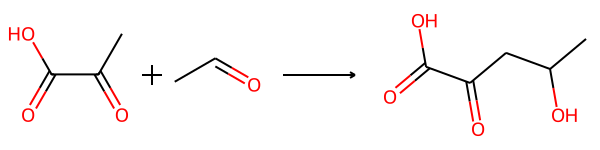

In [110]:

AllChem.ReactionFromSmarts(krsv3[rxnid]['smarts'], useSmiles=True)

In [62]:
print(standardize_smiles('C=CC1=C(C)/C2=C/C3=C(C=C)C(C)=C4/C=C5/C(C)=C(CCC(=O)[O-])C6=[N+]5[Fe-2]5(N43)N3C(=C6)C(CCC(=O)[O-])=C(C)/C3=C/C1=[N+]25', True))
print(standardize_smiles("CC1=C(CCC([O-])=O)C2=[N+]3C1=Cc1c(C)c(C=C)c4C=C5C(C)=C(C=C)C6=[N+]5[Fe--]3(n14)n1c(=C6)c(C)c(CCC([O-])=O)c1=C2", True))
print('C=C1C(=CC)c2cc3[nH]c(cc4[nH]c(cc5nc(cc1n2)C(CC)=C5C)c(C)c4CCC(=O)O)c(C=CC(=O)O)c3C')

[09:26:37] Initializing MetalDisconnector
[09:26:37] Running MetalDisconnector
[09:26:37] Removed covalent bond between Fe and N
[09:26:37] Removed covalent bond between Fe and N
[09:26:37] Removed covalent bond between Fe and N
[09:26:37] Removed covalent bond between Fe and N
[09:26:37] Initializing Normalizer
[09:26:37] Running Normalizer
[09:26:37] Initializing MetalDisconnector
[09:26:37] Running MetalDisconnector
[09:26:37] Initializing Normalizer
[09:26:37] Running Normalizer
[09:26:37] Running LargestFragmentChooser
[09:26:37] Fragment: C=CC1=C(C)c2cc3[n-]c(cc4nc(cc5[n-]c(cc1n2)c(C)c5CCC(=O)[O-])C(CCC(=O)[O-])=C4C)c(C)c3C=C
[09:26:37] New largest fragment: C=CC1=C(C)c2cc3[n-]c(cc4nc(cc5[n-]c(cc1n2)c(C)c5CCC(=O)[O-])C(CCC(=O)[O-])=C4C)c(C)c3C=C (72)
[09:26:37] Fragment: [Fe+2]
[09:26:37] Tautomer enumeration stopped at 364 tautomers: max transforms reached
[09:26:37] Initializing MetalDisconnector
[09:26:37] Running MetalDisconnector
[09:26:37] Removed covalent bond between Fe a

C=C1C(=CC)c2cc3[nH]c(cc4[nH]c(cc5nc(cc1n2)C(CC)=C5C)c(C)c4CCC(=O)O)c(C=CC(=O)O)c3C
C=CC1=C(C)c2cc3[nH]c(cc4[nH]c(cc5nc(cc1n2)=C(C)C5=CCC(=O)O)c(CCC(=O)O)c4C)c(C)c3=CC
C=C1C(=CC)c2cc3[nH]c(cc4[nH]c(cc5nc(cc1n2)C(CC)=C5C)c(C)c4CCC(=O)O)c(C=CC(=O)O)c3C


[09:26:38] Tautomer enumeration stopped at 410 tautomers: max transforms reached


In [51]:
# Check reverses are correct

norev = []
for k,v in krsv3.items():
    smarts = v['smarts']
    rev = v['reverse']
    assert rev is not None
    rev_smarts = smarts.split('>>')[1] + ">>" + smarts.split('>>')[0]
    assert rev_smarts == krsv3[rev]['smarts']

In [76]:
# Check for transport reactions
trans = []
for k,v in krsv3.items():
    if v['reverse'] == k:
        trans.append(k)

In [79]:
for k in trans:
    krsv3.pop(k, None)

# Handle subunits

In [155]:
path = "../data/sprhea/uniprotkb_reviewed_true_AND_proteins_wi_2024_02_29.tsv"
df = pd.read_csv(path, sep='\t')
df.set_index("Entry", inplace=True)
df.head()

,Reviewed,Protein names,Organism,Protein existence,Sequence,Catalytic activity,EC number
Entry,,,,,,,
A0A009IHW8,reviewed,2' cyclic ADP-D-ribose synthase AbTIR (2'cADPR...,Acinetobacter baumannii (strain 1295743),Evidence at protein level,MSLEQKKGADIISKILQIQNSIGKTTSPSTLKTKLSEISRKEQENA...,CATALYTIC ACTIVITY: Reaction=NAD(+) = 2'cADPR ...,3.2.2.-; 3.2.2.6
A0A023I7E1,reviewed,"Glucan endo-1,3-beta-D-glucosidase 1 (Endo-1,3...",Rhizomucor miehei,Evidence at protein level,MRFQVIVAAATITMITSYIPGVASQSTSDGDDLFVPVSNFDPKSIF...,CATALYTIC ACTIVITY: Reaction=Hydrolysis of (1-...,3.2.1.39
A0A024B7W1,reviewed,Genome polyprotein [Cleaved into: Capsid prote...,Zika virus (isolate ZIKV/Human/French Polynesi...,Evidence at protein level,MKNPKKKSGGFRIVNMLKRGVARVSPFGGLKRLPAGLLLGHGPIRM...,CATALYTIC ACTIVITY: [RNA-directed RNA polymera...,2.1.1.56; 2.1.1.57; 2.7.7.48; 3.4.21.91; 3.6.1...
A0A024SC78,reviewed,Cutinase (EC 3.1.1.74),Hypocrea jecorina (strain ATCC 56765 / BCRC 32...,Evidence at protein level,MRSLAILTTLLAGHAFAYPKPAPQSVNRRDWPSINEFLSELAKVMP...,CATALYTIC ACTIVITY: Reaction=cutin + H2O = cut...,3.1.1.74
A0A024SH76,reviewed,"Exoglucanase 2 (EC 3.2.1.91) (1,4-beta-cellobi...",Hypocrea jecorina (strain ATCC 56765 / BCRC 32...,Evidence at protein level,MIVGILTTLATLATLAASVPLEERQACSSVWGQCGGQNWSGPTCCA...,CATALYTIC ACTIVITY: Reaction=Hydrolysis of (1-...,3.2.1.91


In [156]:
len(df)

255081

In [165]:
nanless = df.loc[~df['Protein names'].isna()]
subunits = nanless.loc[nanless['Protein names'].str.contains('subunit')].sort_values(by='Protein names')

In [163]:
print(len(subunits))
subunits.head(30)

40097


,Reviewed,Protein names,Organism,Protein existence,Sequence,Catalytic activity,EC number
Entry,,,,,,,
Q1QWP1,reviewed,(2R)-sulfolactate sulfo-lyase subunit alpha (E...,Chromohalobacter salexigens (strain ATCC BAA-1...,Evidence at protein level,MSIDFVVHDADDAVGVVVVEGVEAGQMLTGWVMDQDRTLQFEVKDA...,CATALYTIC ACTIVITY: Reaction=(2R)-3-sulfolacta...,4.4.1.24
Q58Y44,reviewed,(2R)-sulfolactate sulfo-lyase subunit alpha (E...,Paracoccus pantotrophus (Thiosphaera pantotropha),Evidence at protein level,MLCVVTSDNSDFRLTAKADIPIGHKVALKALKAGDTVIKYHEDIGK...,CATALYTIC ACTIVITY: Reaction=(2R)-3-sulfolacta...,4.4.1.24
Q58Y43,reviewed,(2R)-sulfolactate sulfo-lyase subunit beta (EC...,Paracoccus pantotrophus (Thiosphaera pantotropha),Evidence at protein level,MALDFSNATVKAWRRENGRVGVRNHVLILPVDDISNAACEAVANNV...,CATALYTIC ACTIVITY: Reaction=(2R)-3-sulfolacta...,4.4.1.24
Q1QWP0,reviewed,(2R)-sulfolactate sulfo-lyase subunit beta (EC...,Chromohalobacter salexigens (strain ATCC BAA-1...,Evidence at protein level,MELKGRTFLGYRRDNGRVGIRNHVIVLPVDDISNAAAEAVANNIKG...,CATALYTIC ACTIVITY: Reaction=(2R)-3-sulfolacta...,4.4.1.24
Q9KJF1,reviewed,(2S)-[(R)-hydroxy(phenyl)methyl]succinyl-CoA d...,Thauera aromatica,Evidence at protein level,MGIQNRVALITGSASGMGKQTALRFAEQGAAVVINDIDAEKVRATV...,CATALYTIC ACTIVITY: Reaction=(2S)-[(R)-hydroxy...,1.1.1.429
Q9XT00,reviewed,(3R)-3-hydroxyacyl-CoA dehydrogenase (EC 1.1.1...,Sus scrofa (Pig),Inferred from homology,MASQLRLRSALALVTGAGSGIGRAVSVRLAAEGAAVAACDLDGAAA...,CATALYTIC ACTIVITY: Reaction=a (3R)-3-hydroxya...,1.1.1.239; 1.1.1.62; 1.1.1.n12
P50171,reviewed,(3R)-3-hydroxyacyl-CoA dehydrogenase (EC 1.1.1...,Mus musculus (Mouse),Evidence at protein level,MASQLRLRSALALVTGAGSGIGRAISVRLAAEGAAVAACDLDGAAA...,CATALYTIC ACTIVITY: Reaction=a (3R)-3-hydroxya...,1.1.1.239; 1.1.1.62; 1.1.1.n12
Q6MGB5,reviewed,(3R)-3-hydroxyacyl-CoA dehydrogenase (EC 1.1.1...,Rattus norvegicus (Rat),Evidence at protein level,MASQLRLRSALALVTGAGSGIGRAISVRLAAEGAAVAACDLDGAAA...,CATALYTIC ACTIVITY: Reaction=a (3R)-3-hydroxya...,1.1.1.239; 1.1.1.62; 1.1.1.n12
Q5TJF5,reviewed,(3R)-3-hydroxyacyl-CoA dehydrogenase (EC 1.1.1...,Canis lupus familiaris (Dog) (Canis familiaris),Inferred from homology,MASPLRLRSALALVTGAGSGIGRAVSVRLAKEGATVAACDLDRAAA...,CATALYTIC ACTIVITY: Reaction=a (3R)-3-hydroxya...,1.1.1.239; 1.1.1.62; 1.1.1.n12


In [169]:
subunits.to_csv('../data/sprhea/subunits_240310.tsv', sep='\t')

# RC-MCS investigation

In [18]:
from src.rxn_ctr_mcs import get_lhs_patts_from_operator
import pandas as pd
from collections import defaultdict

In [4]:
min_rules = pd.read_csv(
    '/home/stef/bottle/data/mapping/minimal1224_all_uniprot.tsv',
    sep='\t'
    )
min_rules.head()

,Name,Reactants,SMARTS,Products,Comments
0,rule0001,Any;Any,[#6:1]-[#8:2].[#8:3]>>[#6:1]-[#8:3].[#8:2],Any;Any,A0A060PLD9;A0A0P0YNP7;A0A0P9RZM9;A1XCQ0;A3E242...
1,rule0002,Any;NAD_CoF,[#6:1]-[#8:2].[#6:3]1:[#6:4]:[#6:5]:[#6:6]:[#7...,NADH_CoF;Any,A0A023RBJ1;A0A060KZ16;A0A060TBM3;A0A072UJB3;A0...
2,rule0003,NADH_CoF;Any,[#6:1]1=[#6:2]-[#7:3]-[#6:4]=[#6:5]-[#6:6]-1.[...,Any;NAD_CoF,A0A023RBJ1;A0A060KZ16;A0A060TBM3;A0A072UJB3;A0...
3,rule0004,Any;NADH_CoF;O2,[#6:1].[#6:2]1=[#6:3]-[#7:4]-[#6:5]=[#6:6]-[#6...,Any;NAD_CoF;WATER,A0A1P8W705;A0A250DUW2;A1Z745;A5HMH6;A5HMH7;A5H...
4,rule0005,Any;NAD_CoF;WATER,[#6:1]-[#8:2].[#6:3]1:[#6:4]:[#6:5]:[#6:6]:[#7...,Any;NADH_CoF;O2,A0A1P8W705;A0A250DUW2;A1Z745;A5HMH6;A5HMH7;A5H...


In [22]:
duplicate_patts = []
for i, row in min_rules.iterrows():
    patts = get_lhs_patts_from_operator(row['SMARTS'])
    lhs = row['SMARTS'].split('>>')[0]
    template_names = row['Reactants'].split(';')

    patt_name = defaultdict(list)
    for patt, name in zip(patts, template_names):
        patt_name[patt].append(name)

    if len(patts) != len(set(patts)):
        duplicate_patts.append([row['Name'], patt_name])
    
    print(lhs, '-->', patts)

[#6:1]-[#8:2].[#8:3] --> ['[#6]-[#8]', '[#8]']
[#6:1]-[#8:2].[#6:3]1:[#6:4]:[#6:5]:[#6:6]:[#7+:7]:[#6:8]:1 --> ['[#6]-[#8]', '[#6]1:[#6]:[#6]:[#6]:[#7+]:[#6]:1']
[#6:1]1=[#6:2]-[#7:3]-[#6:4]=[#6:5]-[#6:6]-1.[#6:7]=[#8:8] --> ['[#6]1=[#6]-[#7]-[#6]=[#6]-[#6]-1', '[#6]=[#8]']
[#6:1].[#6:2]1=[#6:3]-[#7:4]-[#6:5]=[#6:6]-[#6:7]-1.[#8:8]=[#8:9] --> ['[#6]', '[#6]1=[#6]-[#7]-[#6]=[#6]-[#6]-1', '[#8]=[#8]']
[#6:1]-[#8:2].[#6:3]1:[#6:4]:[#6:5]:[#6:6]:[#7+:7]:[#6:8]:1.[#8:9] --> ['[#6]-[#8]', '[#6]1:[#6]:[#6]:[#6]:[#7+]:[#6]:1', '[#8]']
[#6:1]-[#8:2].[#8:3] --> ['[#6]-[#8]', '[#8]']
[#6:1]-[#8:2].[#8:3] --> ['[#6]-[#8]', '[#8]']
[#6:1]-[#8:2].[#8:3] --> ['[#6]-[#8]', '[#8]']
[#6:1]-[#8:2].[#8:3] --> ['[#6]-[#8]', '[#8]']
[#16:1].[#6:2]-[#8:3] --> ['[#16]', '[#6]-[#8]']
[#6:1]-[#16+:2].[#8:3] --> ['[#6]-[#16+]', '[#8]']
[#6:1]-[#8:2].[#7:3] --> ['[#6]-[#8]', '[#7]']
[#6:1]-[#7:2].[#8:3] --> ['[#6]-[#7]', '[#8]']
[#8:1].[#8:2]-[#15:3] --> ['[#8]', '[#8]-[#15]']
[#8:1].[#8:2]-[#15:3] --> ['[#8]', '

In [23]:
duplicate_patts

[['rule0044',
  defaultdict(list, {'[#6]-[#8]': ['Any', 'Any'], '[#6]=[#8]': ['CO2']})],
 ['rule0072',
  defaultdict(list,
              {'[#6]1:[#6]:[#6]:[#6]:[#7+]:[#6]:1': ['NAD_CoF'],
               '[#6]=[#8]': ['Any'],
               '[#8]': ['WATER', 'WATER']})],
 ['rule0117', defaultdict(list, {'[#6]=[#8]': ['Any', 'Any']})],
 ['rule0149',
  defaultdict(list,
              {'[#6]-[#8]': ['Any'],
               '[#6]1:[#6]:[#6]:[#6]:[#7+]:[#6]:1': ['NAD_CoF'],
               '[#8]': ['WATER', 'WATER']})],
 ['rule0164',
  defaultdict(list,
              {'[#6]1=[#6]-[#7]-[#6]=[#6]-[#6]-1': ['NADH_CoF', 'NADH_CoF'],
               '[#6]=[#8]': ['Any']})],
 ['rule0165',
  defaultdict(list,
              {'[#6]': ['Any'],
               '[#6]1:[#6]:[#6]:[#6]:[#7+]:[#6]:1': ['NAD_CoF', 'NAD_CoF'],
               '[#8]': ['WATER']})],
 ['rule0179',
  defaultdict(list,
              {'[#16]': ['CoA'],
               '[#6]-[#8]': ['Any'],
               '[#6]1:[#6]:[#6]:[#6]:[#7+]:[#6]:

In [32]:
min_rules.loc[43, 'SMARTS']

'[#6:1]-[#8:2].[#6:3]-[#8:4].[#6:5]=[#8:6]>>[#6:1].[#6:3]-[#6:5]-[#8:6].[#8:2]=[#8:4]'

# Handy little viz fcn

In [146]:
from IPython.display import SVG # to use Scalar Vector Graphics (SVG) not bitmaps, for cleaner lines

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw # to draw molecules
from rdkit.Chem.Draw import IPythonConsole # to draw inline in iPython
from rdkit.Chem import rdDepictor  # to generate 2D depictions of molecules
from rdkit.Chem.Draw import rdMolDraw2D # to draw 2D molecules using vectors
from rdkit.Chem.MolStandardize import rdMolStandardize

def draw_mol_with_SVG(mol, molSize=(450,150)):
    """Use SVG to draw an RDKit molecule, mol."""
    mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():        
        rdDepictor.Compute2DCoords(mc) # Compute 2D coordinates
    # Initialize the drawer with the size
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc) # Draw the molcule
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText() # Get the SVG string
    display(SVG(svg.replace('svg:',''))) # Fix the SVG string and display